# Complexity Progression
This notebook explores the progression of complexity for Stack Overflow users with \[mysql\] tagged questions.

In [ ]:
# Install required modules.
!pip install -r requirements.txt

In [1]:
import database
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [9]:
db = database.Database("stackoverflow_mysql_queries")

sns.set_context("notebook", font_scale=1.25)

In [3]:
##################
##  CONSTANTS   ##
##################

# Threshold for the minimum questions by a single user.
MIN_QUESTIONS = 3
# Threshold for the maximum questions by a single user.
MAX_QUESTIONS = 25
# Threshold for the maximum SQL complexity (skip outliers).
MAX_SQL_COMPLEXITY=250
# Threshold for the maximum language complexity (skip outliers).
MAX_LANGUAGE_COMPLEXITY=500

In [4]:
# Select all questions for users with multiple questions.
# Each row has an `Ordering` column which numerically indicates the sequence number of the question.
df_sql_complexity = db.query_df(
    {
        "SELECT": "f.QuestionId, f.QuestionUserId, fs.QuestionSQLComplexity, ROW_NUMBER() OVER (PARTITION BY QuestionUserId ORDER BY QuestionCreationDate) AS Ordering",
        "FROM": "features f JOIN features_sql fs ON f.QuestionId = fs.QuestionId",
        "WHERE": "QuestionUserId IN (SELECT QuestionUserId FROM features GROUP BY QuestionUserId HAVING COUNT(QuestionUserId) >= {} AND COUNT(QuestionUserId) <= {}) AND fs.QuestionSQLComplexity <= {}".format(
            MIN_QUESTIONS,
            MAX_QUESTIONS,
            MAX_SQL_COMPLEXITY
        ),
        "ORDER BY": "f.QuestionUserId ASC, f.QuestionCreationDate ASC",
    }
)

In [5]:
df_language_complexity = db.query_df(
    {
        "SELECT": "QuestionId, QuestionUserId, QuestionCreationDate, QuestionLanguageComplexity, ROW_NUMBER() OVER (PARTITION BY QuestionUserId ORDER BY QuestionCreationDate) AS Ordering",
        "FROM": "features",
        "WHERE": "QuestionUserId IN (SELECT QuestionUserId FROM features GROUP BY QuestionUserId HAVING COUNT(QuestionUserId) >= {} AND COUNT(QuestionUserId) <= {}) AND QuestionLanguageComplexity <= {}".format(
            MIN_QUESTIONS,
            MAX_QUESTIONS,
            MAX_LANGUAGE_COMPLEXITY
        ),
        "ORDER BY": "QuestionUserId ASC, QuestionCreationDate ASC",
    }
)

In [6]:
df_sql_components = db.query_df(
    {
        "SELECT": """
    f.QuestionId,
    f.QuestionUserId,
    fs.QuestionSQLComplexity,
    fs.QuestionSQLSubqueries,
    
    fs.QuestionSQLExprInSelect,
    fs.QuestionSQLExprInFrom,
    fs.QuestionSQLExprInWhere,
    fs.QuestionSQLExprInGroupBy,
    fs.QuestionSQLExprInHaving,
    fs.QuestionSQLExprInOrderBy,
    fs.QuestionSQLExprInLimit,
    fs.QuestionSQLExprInOffset,

    fs.QuestionSQLExprUnary,
    fs.QuestionSQLExprBinary,
    fs.QuestionSQLExprColumn,
    fs.QuestionSQLExprNumber,
    fs.QuestionSQLExprAggregation,
    fs.QuestionSQLExprList,
    fs.QuestionSQLExprStar,
    fs.QuestionSQLExprFunction,
    fs.QuestionSQLExprString,
    ROW_NUMBER() OVER (PARTITION BY f.QuestionUserId ORDER BY f.QuestionCreationDate) AS Ordering
    """,
        "FROM": "features f JOIN features_sql fs ON f.QuestionId = fs.QuestionId",
        "WHERE": "f.QuestionUserId IN (SELECT QuestionUserId FROM features GROUP BY QuestionUserId HAVING COUNT(QuestionUserId) >= 3 AND COUNT(QuestionUserId) <= 25) AND fs.QuestionSQLComplexity IS NOT NULL",
        "ORDER BY": "f.QuestionUserId ASC, f.QuestionCreationDate ASC",
    }
)
df_sql_components[
    "QuestionSQLComplexity"
] = df_sql_components["QuestionSQLComplexity"].astype("float")

In [7]:
df_pairplot = db.query_df(
    {
        "SELECT": "QuestionSQLComplexity, QuestionSQLExprInFrom, QuestionSQLExprInWhere, QuestionSQLExprInGroupBy, QuestionSQLExprInHaving, QuestionSQLExprInOrderBy, QuestionSQLExprInLimit, QuestionSQLExprInOffset",
        "FROM": "features_sql",
        "WHERE": "QuestionSQLParseError = 0 AND QuestionSQLComplexity <= 100",
    }
)

## SQL Complexity Progression
### Progression of subcultures
The subcultures "php", "java" and "python" (tags that are also on a question) are grouped and have their progression visualized. Note that there is a lack of data for java and python. In order to improve this, the dataset should be expanded to possibly outside the realm of mysql. However, this requires additional testing for the SQompLexity metric.

In [31]:
# Outdated code: draw a line for each user progression (ends up cluttered and slow).

# df_pivoted_sql_complexity = df_sql_complexity.pivot(index=['Ordering'], columns=['QuestionUserId'], values=['QuestionSQLComplexity'])
# df_pivoted_sql_complexity.columns =  df_pivoted_sql_complexity.columns.droplevel()
# display(df_pivoted_sql_complexity.shape)
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
# fig.tight_layout()
# sns.lineplot(data=df_pivoted_sql_complexity, errorbar=None, ax=ax[1])

php maximum questions by a single user: 6
php maximum SQL complexity: 50.00000000
java maximum questions by a single user: 3
java maximum SQL complexity: 49.78130000
python maximum questions by a single user: 3
python maximum SQL complexity: 48.96880000
mysql maximum questions by a single user: 9
mysql maximum SQL complexity: 50.00000000


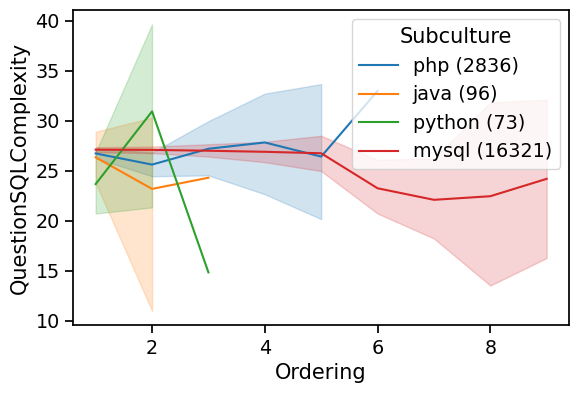

In [17]:
# Subcultures
subcultures = {}

for subculture in ['php', 'java', 'python', 'mysql']:
    subcultures[subculture] = db.query_df(
        {
            "SELECT": "f.QuestionId, f.QuestionUserId, fs.QuestionSQLComplexity, ROW_NUMBER() OVER (PARTITION BY QuestionUserId ORDER BY QuestionCreationDate) AS Ordering",
            "FROM": "features f JOIN features_sql fs ON f.QuestionId = fs.QuestionId JOIN posts p ON f.QuestionId = p.Id",
            "WHERE": "QuestionUserId IN (SELECT QuestionUserId FROM features GROUP BY QuestionUserId HAVING COUNT(QuestionUserId) >= {} AND COUNT(QuestionUserId) <= {}) AND fs.QuestionSQLComplexity <= {} AND p.Tags LIKE '%<{}>%'".format(
                2, # MIN_QUESTIONS
                10, # MAX_QUESTIONS
                50, # MAX_SQL_COMPLEXITY
                subculture
            ),
            "ORDER BY": "f.QuestionUserId ASC, f.QuestionCreationDate ASC",
        }
    )
    # Assign extra column with the subculture name.
    subcultures[subculture]["Subculture"] = subculture + " ({})".format(subcultures[subculture].shape[0])
    print(
        f"{subculture} maximum questions by a single user: {subcultures[subculture].groupby('QuestionUserId').size().max()}"
    )
    print(
        f"{subculture} maximum SQL complexity: {subcultures[subculture]['QuestionSQLComplexity'].max()}"
    )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
fig.tight_layout()
my_fig = sns.lineplot(data=pd.concat(subcultures), x="Ordering", y="QuestionSQLComplexity", errorbar=('ci', 95), hue="Subculture", ax=ax)
my_fig.get_figure().savefig('figures/subcultures-progression.svg', bbox_inches="tight")

In [45]:
def normalize_column(column) -> pd.Series:
    """
    Min-max normalizer for a dataframe (maps values between 0 and 1).
    :param pandas.core.series.Series column
    :param
    """
    min_value = column.min()
    max_value = column.max()
    return (column - min_value) / (max_value - min_value)


def normalize_column_between(column, min, max) -> pd.Series:
    """
    Normalize column between 2 values.
    :param pandas.core.series.Series column
    :param int min
    :param int max
    """
    min_value = column.min()
    max_value = column.max()
    return ((column - min_value) * (max - min) / (max_value - min_value)) + min


def sample_and_repeat(min_rows_per_group):
    """
    Sample and repeat a grouped dataframe, such that each group has the minimum number of rows.
    For groups with less than this number of rows, repetitions take place until the minimum is reached.
    This stratifies each group to have approximately the same number of elements which aids in data representation.
    :param int min_rows_per_group
    """

    def inner(group):
        n = len(group)
        if n < min_rows_per_group:
            repeat_times = (min_rows_per_group - n) // n + 1
            return pd.concat([group] * repeat_times, ignore_index=True).sample(
                min_rows_per_group, replace=True, random_state=1
            )
        else:
            return group.head(min_rows_per_group)

    return inner


def plot_scatter(
    ax,
    df,
    x_column,
    y_column,
    x_label,
    y_label,
    x_lim=None,
    y_lim=None,
    legend_title=None,
    scatter_kws={"alpha": 0.2},
) -> None:
    """
    Print a scatterplot.
    """
    df = df.copy()
    # df['Ordering'] = normalize_column_between(df['Ordering'], 1, 10).astype('float')
    df[x_column] = df[x_column].astype("float")

    if x_lim:
        ax.set_xlim(*x_lim)
    if y_lim:
        ax.set_ylim(*y_lim)
    x = df[x_column]
    y = df[y_column]
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    sns.scatterplot(data=df, x=x, y=y, s=50, linewidth=0, ax=ax, **scatter_kws)
    if legend_title:
        ax.legend(title=legend_title, fancybox=True, framealpha=0.5, loc="upper right")
    pass


def plot_aggregates(ax, column, xlabel, ylabel, df) -> None:
    df[column] = df[column].astype("float")
    sns.pointplot(
        data=df,
        x="Ordering",
        y=column,
        errorbar="ci",
        capsize=0.4,
        markers=".",
        errwidth=1,
        ax=ax,
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for i, artist in enumerate(ax.lines):
        if i == 0:
            # Skip main line.
            artist.set_alpha(0.5)
            continue
        artist.set_color("red")
        artist.set_alpha(0.5)
    pass


def filter_percentile(df, start=0.1, end=0.9) -> pd.DataFrame:
    p_start = df.quantile(start)
    p_end = df.quantile(end)

    df = df.copy()

    for column in df.columns:
        df = df[(df[column] >= p_start[column]) & (df[column] <= p_end[column])]

    return df

### Global progression
The following graphs are taken over the whole population.

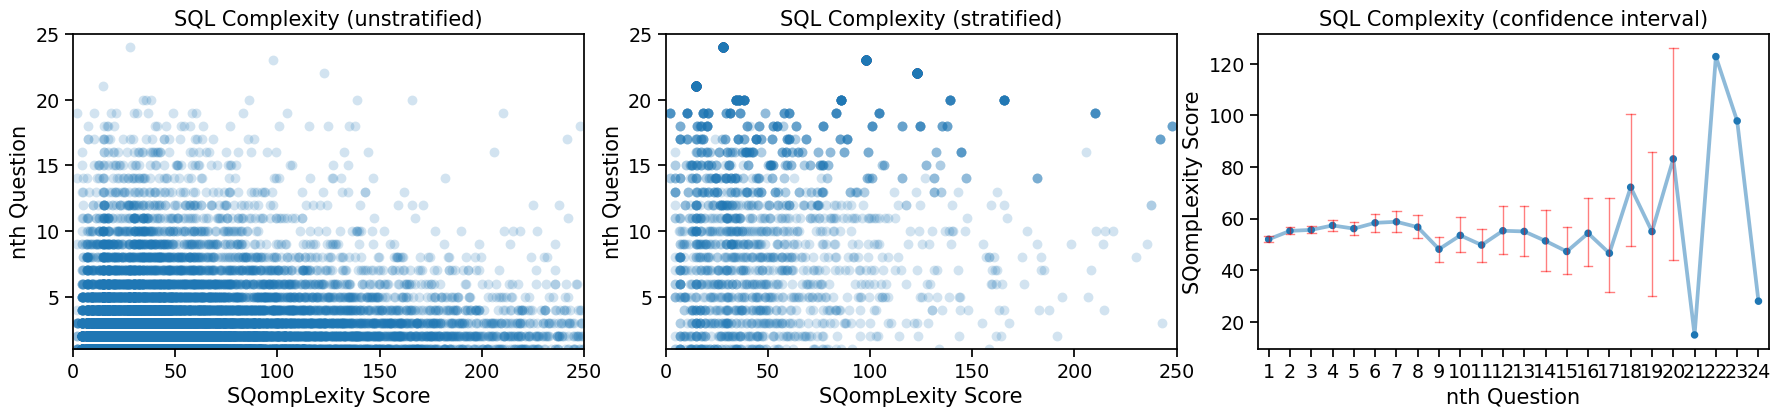

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.tight_layout()
# Unstratified:
plot_scatter(
    ax[0],
    df_sql_complexity,
    "QuestionSQLComplexity",
    "Ordering",
    "SQompLexity Score",
    "nth Question",
    (0, 250),
    (1, 25),
)
ax[0].title.set_text('SQL Complexity (unstratified)')
# Stratified:
plot_scatter(
    ax[1],
    df_sql_complexity.groupby("Ordering").apply(
        sample_and_repeat(100)
    ),
    "QuestionSQLComplexity",
    "Ordering",
    "SQompLexity Score",
    "nth Question",
    (0, 250),
    (1, 25),
)
ax[1].title.set_text('SQL Complexity (stratified)')
# Mean + confidence interval:
plot_aggregates(ax[2], "QuestionSQLComplexity", "nth Question", "SQompLexity Score", df_sql_complexity)
ax[2].title.set_text('SQL Complexity (confidence interval)')
fig.savefig("figures/sqomplexity-progression.png", bbox_inches="tight")

## Language Complexity Progression

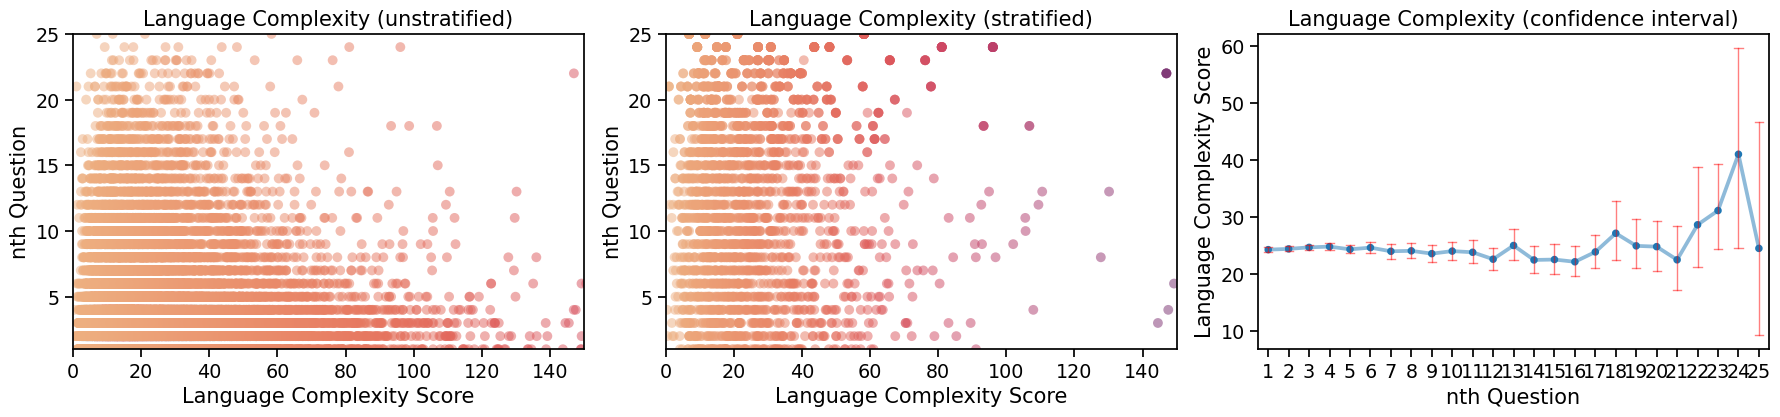

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.tight_layout()

palette = sns.color_palette("flare", as_cmap=True)

plot_scatter(
    ax[0],
    df_language_complexity,
    "QuestionLanguageComplexity",
    "Ordering",
    "Language Complexity Score",
    "nth Question",
    (0, 150),
    (1, 25),
    scatter_kws={"alpha": 0.5, "palette": palette, "hue": "QuestionLanguageComplexity"},
)
ax[0].title.set_text('Language Complexity (unstratified)')
ax[0].legend([],[], frameon=False)

plot_scatter(
    ax[1],
    df_language_complexity.groupby("Ordering").apply(
        sample_and_repeat(100)
    ),
    "QuestionLanguageComplexity",
    "Ordering",
    "Language Complexity Score",
    "nth Question",
    (0, 150),
    (1, 25),
    scatter_kws={"alpha": 0.5, "palette": palette, "hue": "QuestionLanguageComplexity"},
)
ax[1].title.set_text('Language Complexity (stratified)')
ax[1].legend([],[], frameon=False)

# Mean + confidence interval:
plot_aggregates(ax[2], "QuestionLanguageComplexity", "nth Question", "Language Complexity Score", df_language_complexity)
ax[2].title.set_text('Language Complexity (confidence interval)')
fig.savefig('figures/language-progression.png', bbox_inches="tight")

# Appendix
The graphs and results below are not significant enough to derive meaningful conclusions but are included as possible tangents.

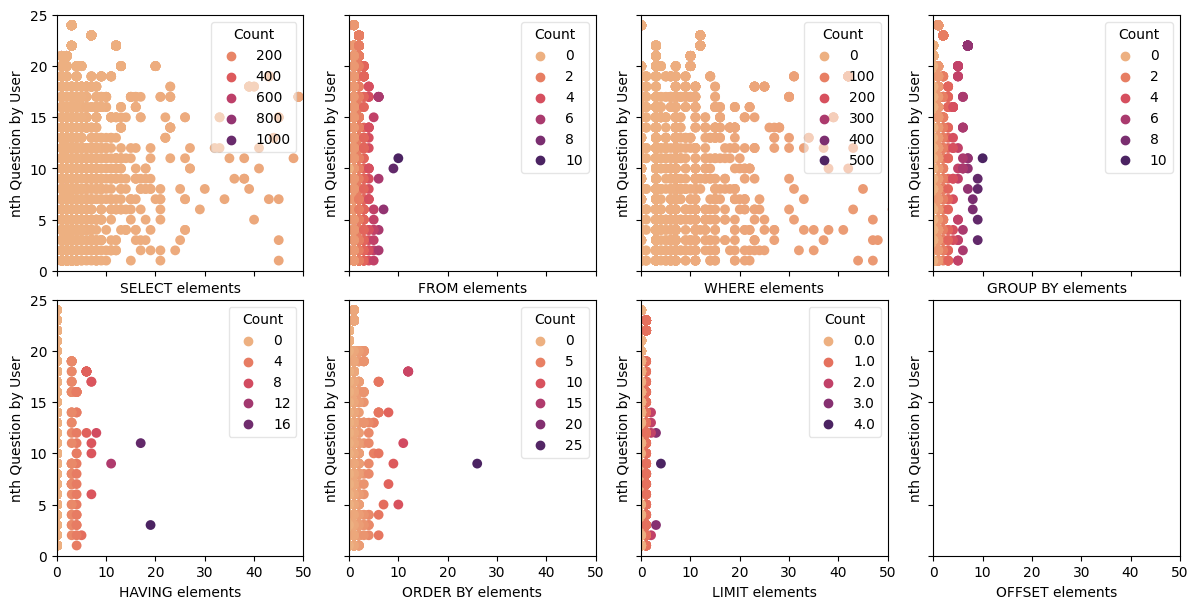

In [20]:
def plot_complexity_per_sql_clause(df):
    df_stratified = df.groupby("Ordering").apply(sample_and_repeat(100))

    fig, ax = plt.subplots(2, 4, sharex="col", sharey="row", figsize=(12, 6))
    palette = sns.color_palette("flare", as_cmap=True)
    fig.tight_layout()

    for i in [
        {
            "loc": (0, 0),
            "xlabel": "SELECT elements",
            "column": "QuestionSQLExprInSelect",
        },
        {"loc": (0, 1), "xlabel": "FROM elements", "column": "QuestionSQLExprInFrom"},
        {"loc": (0, 2), "xlabel": "WHERE elements", "column": "QuestionSQLExprInWhere"},
        {
            "loc": (0, 3),
            "xlabel": "GROUP BY elements",
            "column": "QuestionSQLExprInGroupBy",
        },
        {
            "loc": (1, 0),
            "xlabel": "HAVING elements",
            "column": "QuestionSQLExprInHaving",
        },
        {
            "loc": (1, 1),
            "xlabel": "ORDER BY elements",
            "column": "QuestionSQLExprInOrderBy",
        },
        {"loc": (1, 2), "xlabel": "LIMIT elements", "column": "QuestionSQLExprInLimit"},
        {
            "loc": (1, 3),
            "xlabel": "OFFSET elements",
            "column": "QuestionSQLExprInOffset",
        },
    ]:
        plot_scatter(
            ax[i["loc"]],
            df_stratified,
            i["column"],
            "Ordering",
            i["xlabel"],
            "nth Question by User",
            (0, 50),
            (0, 25),
            legend_title="Count",
            scatter_kws={"palette": palette, "hue": i["column"]},
        )
    pass


try:
    plot_complexity_per_sql_clause(df_sql_components)
except TypeError:
    # Ignore since this might come from an empty table
    pass

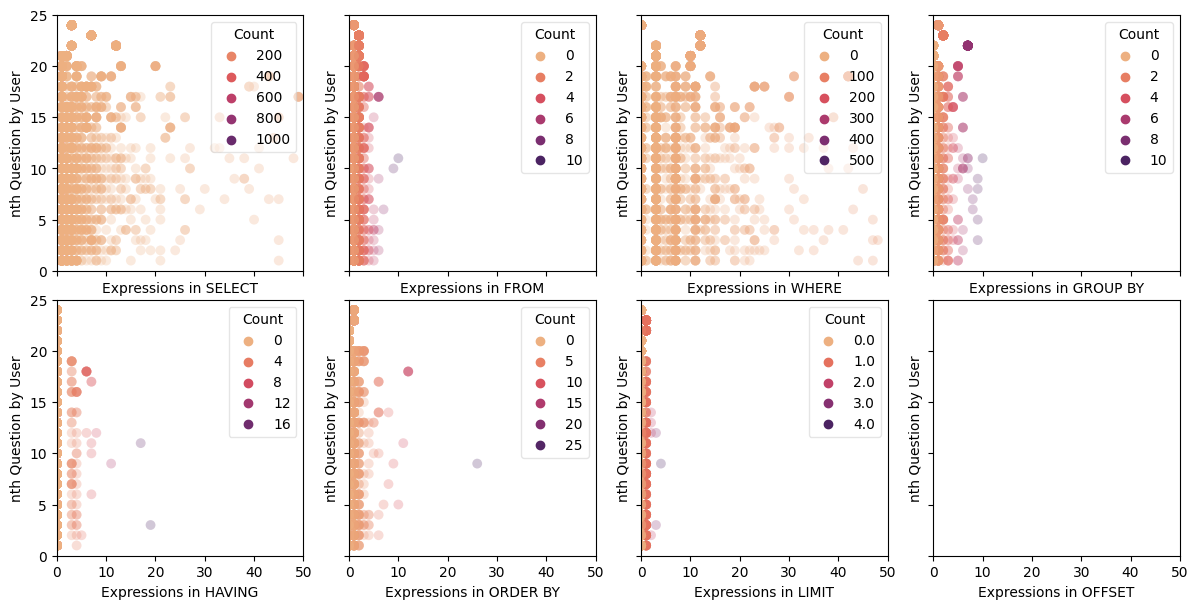

In [21]:
def plot_complexity_per_sql_expression(df):
    df_stratified = df.groupby("Ordering").apply(sample_and_repeat(100))

    fig, ax = plt.subplots(2, 4, sharex="col", sharey="row", figsize=(12, 6))
    palette = sns.color_palette("flare", as_cmap=True)
    fig.tight_layout()

    for i in [
        {
            "loc": (0, 0),
            "xlabel": "Expressions in SELECT",
            "column": "QuestionSQLExprInSelect",
        },
        {
            "loc": (0, 1),
            "xlabel": "Expressions in FROM",
            "column": "QuestionSQLExprInFrom",
        },
        {
            "loc": (0, 2),
            "xlabel": "Expressions in WHERE",
            "column": "QuestionSQLExprInWhere",
        },
        {
            "loc": (0, 3),
            "xlabel": "Expressions in GROUP BY",
            "column": "QuestionSQLExprInGroupBy",
        },
        {
            "loc": (1, 0),
            "xlabel": "Expressions in HAVING",
            "column": "QuestionSQLExprInHaving",
        },
        {
            "loc": (1, 1),
            "xlabel": "Expressions in ORDER BY",
            "column": "QuestionSQLExprInOrderBy",
        },
        {
            "loc": (1, 2),
            "xlabel": "Expressions in LIMIT",
            "column": "QuestionSQLExprInLimit",
        },
        {
            "loc": (1, 3),
            "xlabel": "Expressions in OFFSET",
            "column": "QuestionSQLExprInOffset",
        },
    ]:
        plot_scatter(
            ax[i["loc"]],
            df_stratified,
            i["column"],
            "Ordering",
            i["xlabel"],
            "nth Question by User",
            (0, 50),
            (0, 25),
            legend_title="Count",
            scatter_kws={"alpha": 0.25, "palette": palette, "hue": i["column"]},
        )
    pass


try:
    plot_complexity_per_sql_expression(df_sql_components)
except TypeError:
    # Ignore since this might come from an empty table
    pass

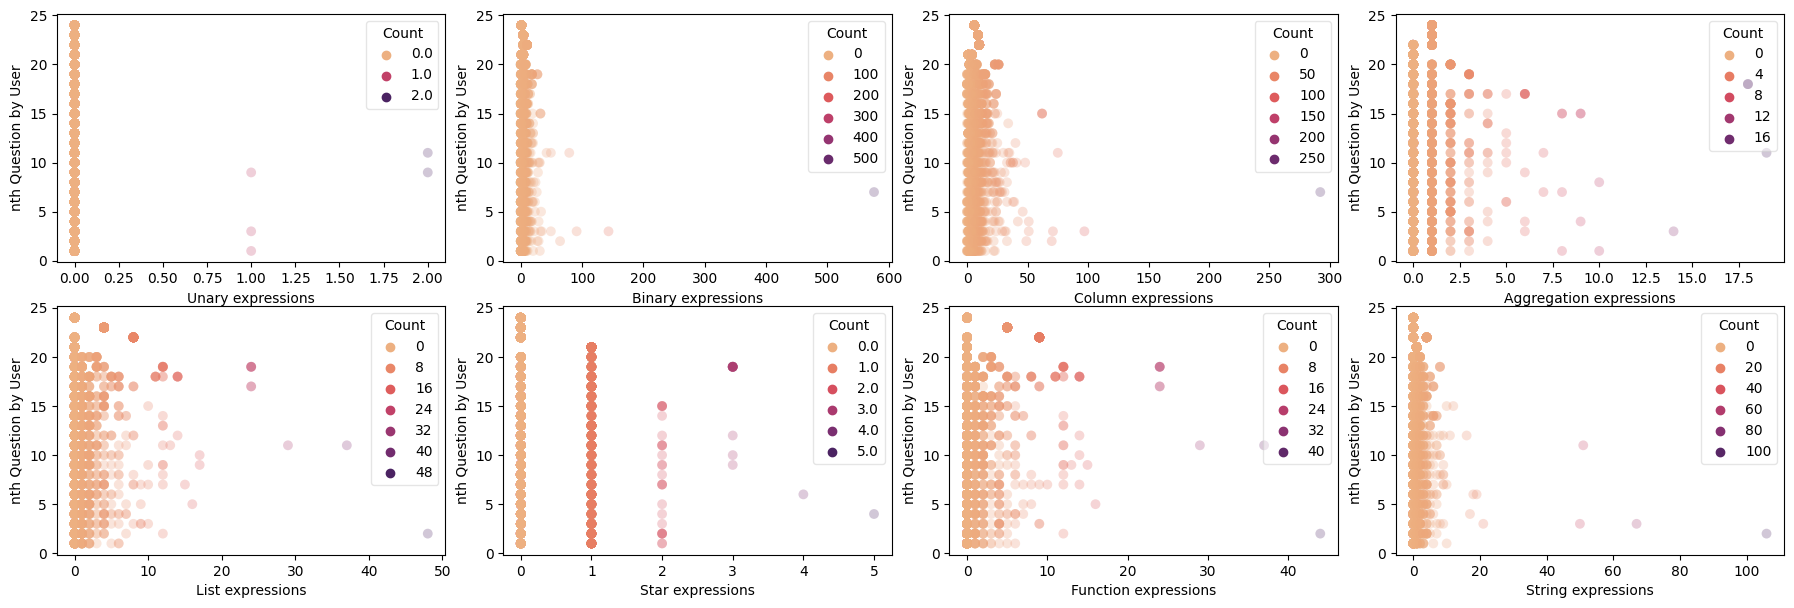

In [14]:
def plot_complexity_per_sql_expression_type(df):
    df_stratified = df.groupby("Ordering").apply(sample_and_repeat(100))

    fig, ax = plt.subplots(2, 4, figsize=(18, 6))
    palette = sns.color_palette("flare", as_cmap=True)
    fig.tight_layout()

    # display(df_sql_components['QuestionSQLSelect'].agg(['min','max']))
    for i in [
        {
            "loc": (0, 0),
            "xlabel": "Unary expressions",
            "column": "QuestionSQLExprUnary",
        },
        {
            "loc": (0, 1),
            "xlabel": "Binary expressions",
            "column": "QuestionSQLExprBinary",
        },
        {
            "loc": (0, 2),
            "xlabel": "Column expressions",
            "column": "QuestionSQLExprColumn",
        },
        {
            "loc": (0, 3),
            "xlabel": "Aggregation expressions",
            "column": "QuestionSQLExprAggregation",
        },
        {"loc": (1, 0), "xlabel": "List expressions", "column": "QuestionSQLExprList"},
        {"loc": (1, 1), "xlabel": "Star expressions", "column": "QuestionSQLExprStar"},
        {
            "loc": (1, 2),
            "xlabel": "Function expressions",
            "column": "QuestionSQLExprFunction",
        },
        {
            "loc": (1, 3),
            "xlabel": "String expressions",
            "column": "QuestionSQLExprString",
        },
    ]:
        plot_scatter(
            ax[i["loc"]],
            df_stratified,
            i["column"],
            "Ordering",
            i["xlabel"],
            "nth Question by User",
            legend_title="Count",
            scatter_kws={"alpha": 0.25, "palette": palette, "hue": i["column"]},
        )
    pass


plot_complexity_per_sql_expression_type(df_sql_components)

In [57]:
def plot_overlay_all_expression_types(ax, df, map, name, x_lim, y_lim, expressions):

    # Change from wide to long format.
    df_melted = df.melt(
        id_vars=["QuestionSQLComplexity"],
        value_vars=map.keys(),
        var_name=name,
        value_name="Value",
    )

    # Rename for brevity.
    df_melted[name] = df_melted[name].map(map)

    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

    # Add some noise to the integer values to distinguish points more easily.
    # The noise is so small that the result is still valid.
    df_melted["Value"] = df_melted["Value"] + np.random.normal(0, 0.5, len(df_melted))
    df_melted["QuestionSQLComplexity"] = df_melted[
        "QuestionSQLComplexity"
    ] + np.random.normal(0, 0.5, len(df_melted))

    sns.scatterplot(
        data=df_melted[df_melted[name].isin(expressions)],
        x="QuestionSQLComplexity",
        y="Value",
        hue=name,
        s=25,
        ax=ax,
        linewidth=0,
        style=name,
        # Set rasterization for all the data points, so we can still save the svg efficiently.
        rasterized=True,
    )

    fig.savefig("plot_overlay_all_expression_types.svg", dpi=300, bbox_inches="tight")
    pass

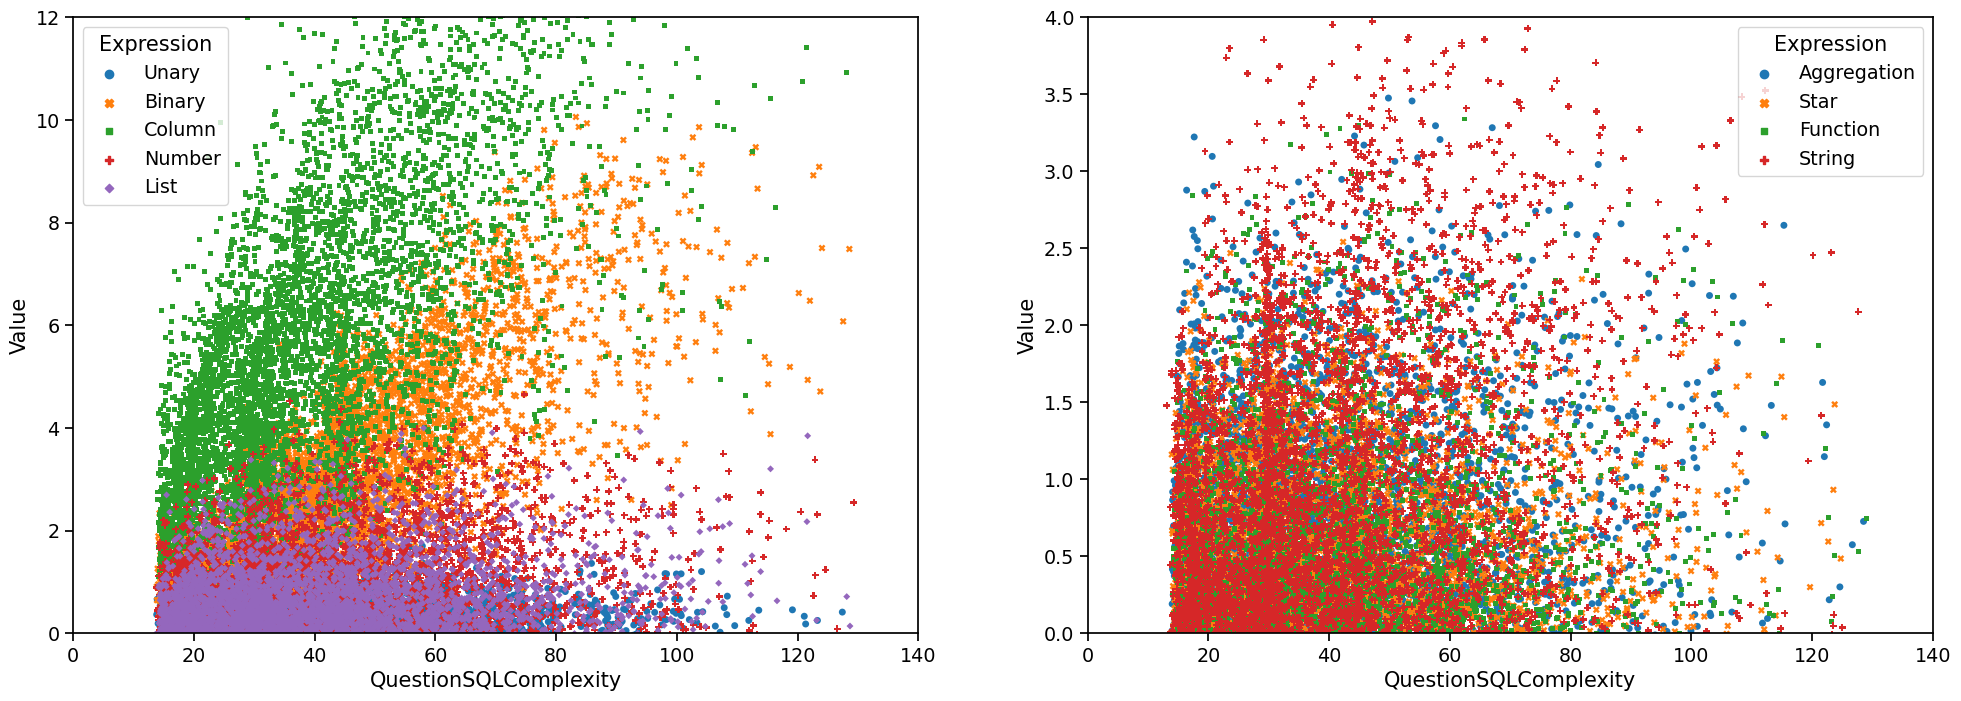

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
plot_overlay_all_expression_types(
    ax[0],
    filter_percentile(df_sql_components, 0.1, 0.9),
    map={
        "QuestionSQLExprUnary": "Unary",
        "QuestionSQLExprBinary": "Binary",
        "QuestionSQLExprColumn": "Column",
        "QuestionSQLExprNumber": "Number",
        "QuestionSQLExprAggregation": "Aggregation",
        "QuestionSQLExprList": "List",
        "QuestionSQLExprStar": "Star",
        "QuestionSQLExprFunction": "Function",
        "QuestionSQLExprString": "String",
    },
    name="Expression",
    x_lim=(0, 140),
    y_lim=(0, 12),
    expressions=["Column", "Unary", "Binary", "Number", "List"],
)
plot_overlay_all_expression_types(
    ax[1],
    filter_percentile(df_sql_components, 0.1, 0.9),
    map={
        "QuestionSQLExprUnary": "Unary",
        "QuestionSQLExprBinary": "Binary",
        "QuestionSQLExprColumn": "Column",
        "QuestionSQLExprNumber": "Number",
        "QuestionSQLExprAggregation": "Aggregation",
        "QuestionSQLExprList": "List",
        "QuestionSQLExprStar": "Star",
        "QuestionSQLExprFunction": "Function",
        "QuestionSQLExprString": "String",
    },
    name="Expression",
    x_lim=(0, 140),
    y_lim=(0, 4),
    expressions=["Aggregation", "Star", "Function", "String"],
)

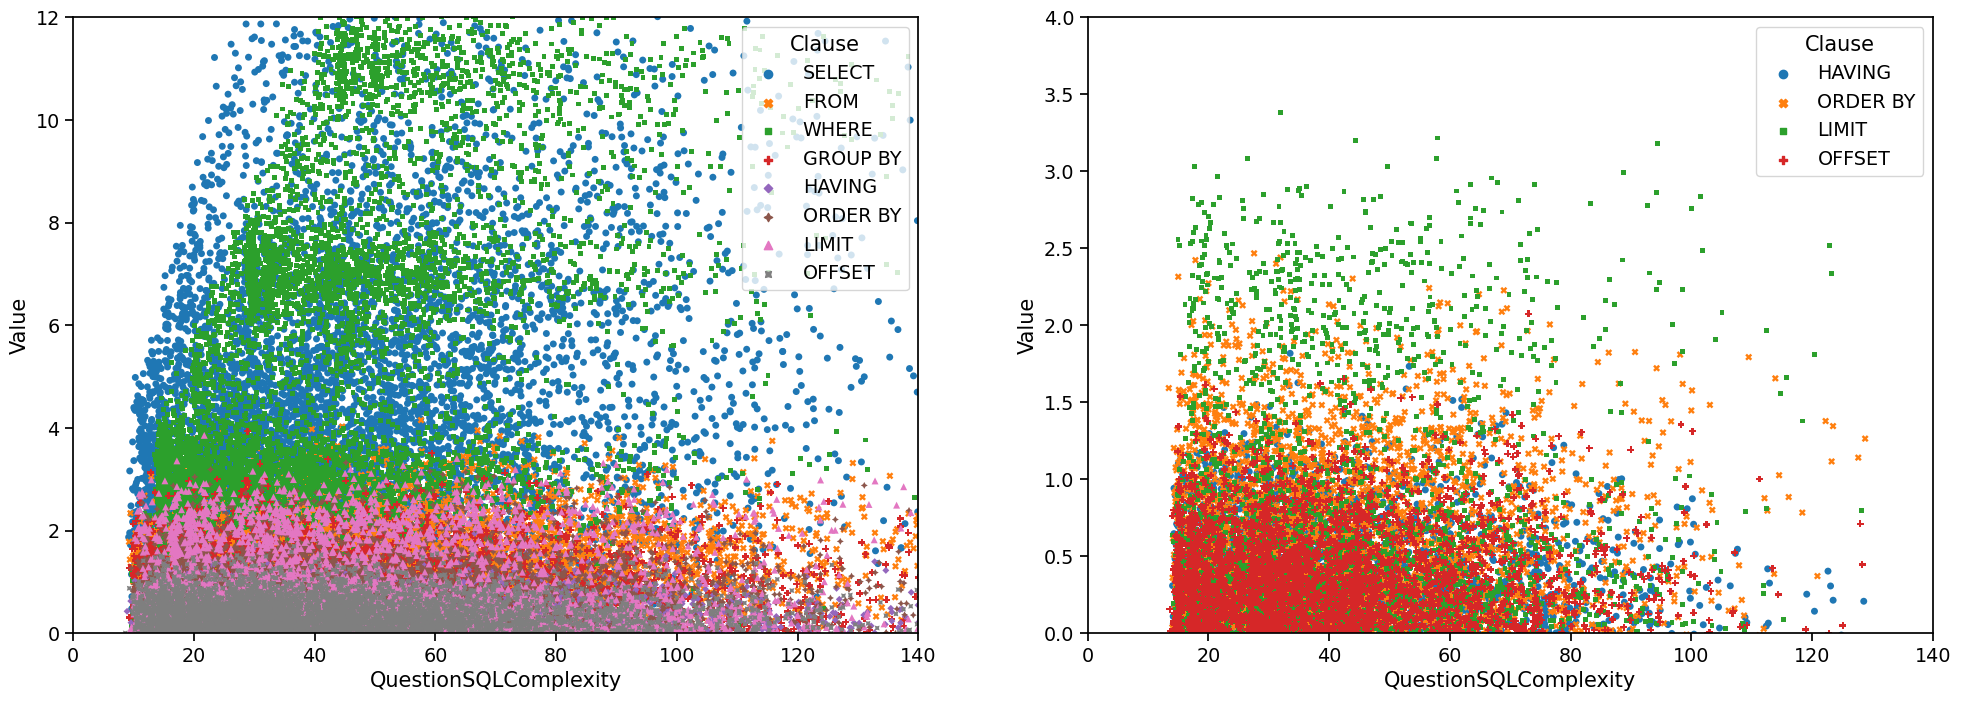

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
plot_overlay_all_expression_types(
    ax[0],
    filter_percentile(df_sql_components, 0.05, 0.95),
    map={
        "QuestionSQLExprInSelect": "SELECT",
        "QuestionSQLExprInFrom": "FROM",
        "QuestionSQLExprInWhere": "WHERE",
        "QuestionSQLExprInGroupBy": "GROUP BY",
        "QuestionSQLExprInHaving": "HAVING",
        "QuestionSQLExprInOrderBy": "ORDER BY",
        "QuestionSQLExprInLimit": "LIMIT",
        "QuestionSQLExprInOffset": "OFFSET",
    },
    name="Clause",
    x_lim=(0, 140),
    y_lim=(0, 12),
    expressions=["SELECT", "FROM", "WHERE", "GROUP BY","HAVING", "ORDER BY", "LIMIT", "OFFSET"],
)
plot_overlay_all_expression_types(
    ax[1],
    filter_percentile(df_sql_components, 0.1, 0.9),
    map={
        "QuestionSQLExprInSelect": "SELECT",
        "QuestionSQLExprInFrom": "FROM",
        "QuestionSQLExprInWhere": "WHERE",
        "QuestionSQLExprInGroupBy": "GROUP BY",
        "QuestionSQLExprInHaving": "HAVING",
        "QuestionSQLExprInOrderBy": "ORDER BY",
        "QuestionSQLExprInLimit": "LIMIT",
        "QuestionSQLExprInOffset": "OFFSET",
    },
    name="Clause",
    x_lim=(0, 140),
    y_lim=(0, 4),
    expressions=["HAVING", "ORDER BY", "LIMIT", "OFFSET"],
)

QuestionSQLComplexity       2.0
QuestionSQLExprInFrom       0.0
QuestionSQLExprInWhere      0.0
QuestionSQLExprInGroupBy    0.0
QuestionSQLExprInHaving     0.0
QuestionSQLExprInOrderBy    0.0
QuestionSQLExprInLimit      0.0
QuestionSQLExprInOffset     0.0
Name: 0.001, dtype: float64

QuestionSQLComplexity       99.643898
QuestionSQLExprInFrom        5.000000
QuestionSQLExprInWhere      25.000000
QuestionSQLExprInGroupBy     9.000000
QuestionSQLExprInHaving     11.000000
QuestionSQLExprInOrderBy    10.000000
QuestionSQLExprInLimit       4.000000
QuestionSQLExprInOffset      2.000000
Name: 0.999, dtype: float64

C:\Anaconda3\envs\2imm00\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


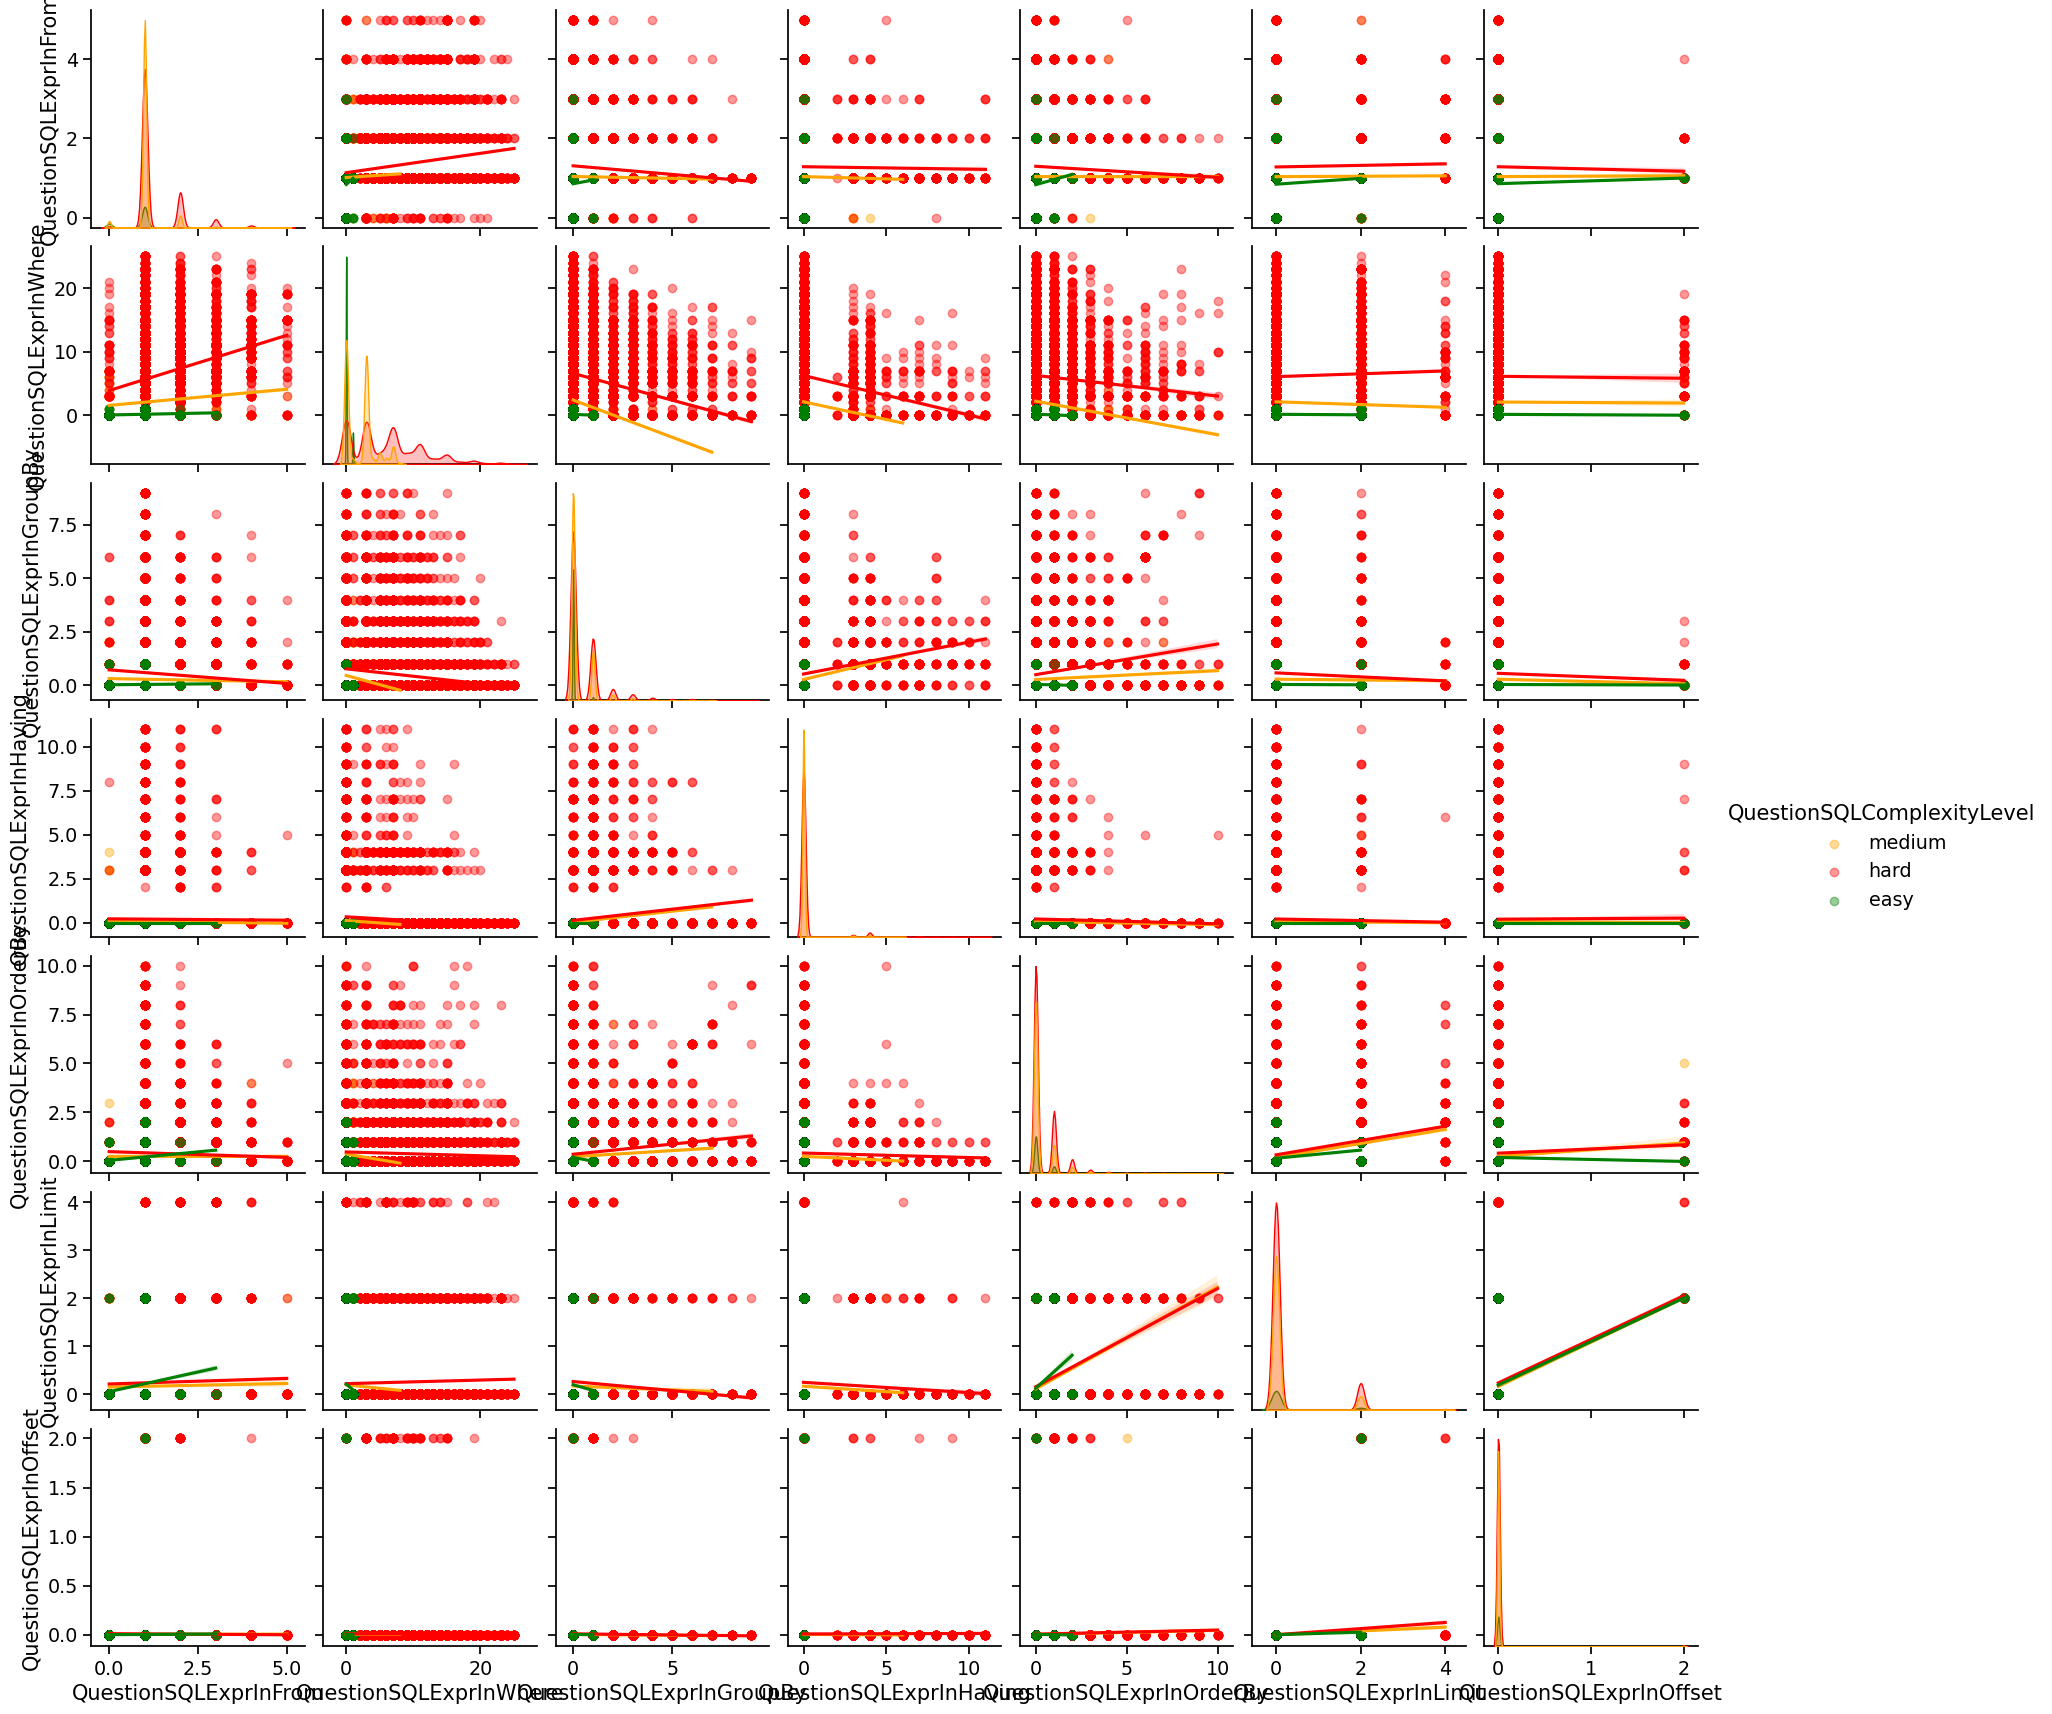

In [65]:
def label_difficulty(number):
    if number <= 10:
        return "easy"
    elif number <= 30:
        return "medium"
    else:
        return "hard"


def filter_pairplot(df):
    df = df.copy().astype("float")
    # Filter outliers.

    percentiles_10 = df.quantile(0.001)
    percentiles_90 = df.quantile(0.999)

    display(percentiles_10)
    display(percentiles_90)

    for column in df.columns:
        df = df[
            (df[column] >= percentiles_10[column])
            & (df[column] <= percentiles_90[column])
        ]

    # Ad some textual difficulty labels based on a predefined segmentation.
    df["QuestionSQLComplexityLevel"] = df["QuestionSQLComplexity"].apply(
        label_difficulty
    )

    return df.loc[:, df.columns != "QuestionSQLComplexity"]

sns.pairplot(
    filter_pairplot(df_pairplot),
    hue="QuestionSQLComplexityLevel",
    kind="reg",
    palette={"easy": "green", "medium": "orange", "hard": "red"},
    plot_kws={"scatter_kws": {"alpha": 0.4}},
)